#### The era5 data is downloaded from the gee platform


In [54]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import rasterio
import pandas as pd
from glob import glob
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from rasterio.features import geometry_mask


In [55]:
path_hma_gtng = 'data/extents/HMA/gtng_202307_hma_subregions.gpkg'
path_era5 = 'data/climate/era5_from_gee/era5_hma.nc'


In [56]:
hma_gtng = gpd.read_file(path_hma_gtng)
dset_era5 = xr.open_dataset(path_era5 )
dset_era5


<xarray.Dataset> Size: 12MB
Dimensions:    (latitude: 241, longitude: 421, time: 5)
Coordinates:
  * latitude   (latitude) float64 2kB 48.05 47.95 47.85 ... 24.25 24.15 24.05
  * longitude  (longitude) float64 3kB 64.95 65.05 65.15 ... 106.8 106.9 107.0
  * time       (time) int64 40B 2000 2005 2010 2015 2020
Data variables:
    t2m        (time, latitude, longitude) float64 4MB ...
    tp         (time, latitude, longitude) float64 4MB ...
    te         (time, latitude, longitude) float64 4MB ...

### Tempreture

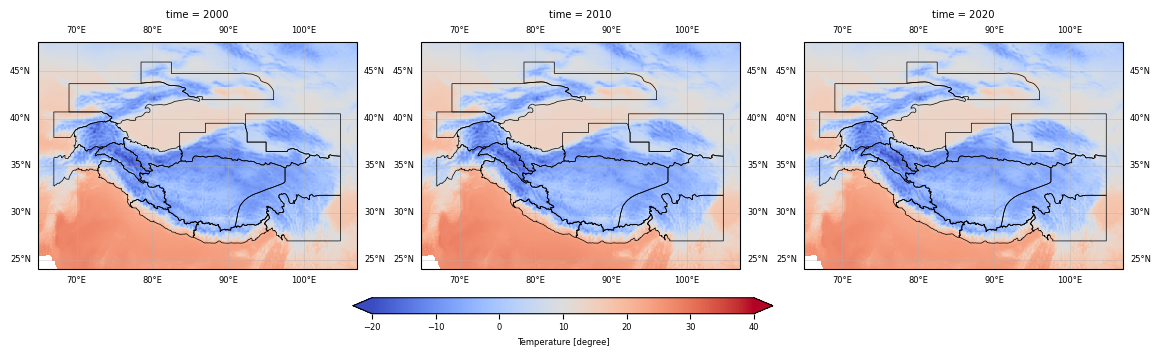

In [57]:
plt.rcParams.update({'font.size':6})
fig = plt.figure(figsize=(14,4))
### temperature in 2000
ax = fig.add_subplot(1,3,1,projection=ccrs.PlateCarree())
# ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.t2m.sel(time=2000).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False, vmin=-20, vmax=40)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
### temperature in 2010
ax = fig.add_subplot(1,3,2,projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.t2m.sel(time=2010).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False, vmin=-20, vmax=40)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
### temperature in 2020
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.t2m.sel(time=2020).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',  add_colorbar=False, vmin=-20, vmax=40)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.04])
fig.colorbar(ax.collections[0], cax=cbar_ax,  label='Temperature [degree]', orientation='horizontal', extend='both', fraction=0.05, pad=0.05)


In [ ]:
# Mask out the region outside of hma_gtng
hma_mask = hma_gtng.geometry.unary_union
transform = rasterio.transform.from_bounds(dset_era5.longitude.min().item(), dset_era5.latitude.min().item(), dset_era5.longitude.max().item(), dset_era5.latitude.max().item(), dset_era5.dims['longitude'], dset_era5.dims['latitude'])
mask = geometry_mask([hma_mask], transform=transform, invert=True, out_shape=(dset_era5.dims['latitude'], dset_era5.dims['longitude']))
mask_da = xr.DataArray(mask, dims=["latitude", "longitude"], coords={"latitude": dset_era5.latitude, "longitude": dset_era5.longitude})
hma_t2m = dset_era5.t2m.where(mask_da, drop=True)
hma_t2m_mean = hma_t2m.mean(dim=['latitude', 'longitude'])
hma_t2m_std = hma_t2m.std(dim=['latitude', 'longitude'])
print(hma_t2m_mean.values)
print(hma_t2m_std.values)


[-0.06086435  0.16814403  0.92243394  0.78921251  0.84257577]
[7.9860662  8.05100276 7.88155449 8.00862441 7.7461325 ]


,time,Mean Temperature,Temperature Std
0,2000,-0.060864,7.986066
1,2005,0.168144,8.051003
2,2010,0.922434,7.881554
3,2015,0.789213,8.008624
4,2020,0.842576,7.746132


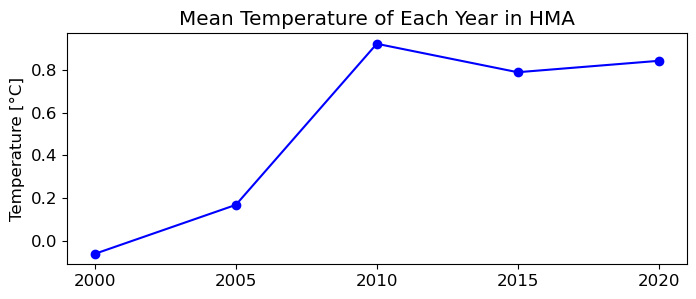

In [75]:
plt.rcParams.update({'font.size': 12})  # Increase font size from 6 to 12
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title('Mean Temperature of Each Year in HMA')
ax.set_ylabel('Temperature [°C]')
hma_t2m_mean_df = hma_t2m_mean.to_dataframe(name='Mean Temperature').reset_index()
hma_t2m_mean_df['Temperature Std'] = hma_t2m_std   ### heterogeneity of temperature in HMA
ax.plot(hma_t2m_mean_df['time'], hma_t2m_mean_df['Mean Temperature'], marker='o', color='b')
valid_years = hma_t2m_mean_df['time']
ax.set_xticks(valid_years)
hma_t2m_mean_df


In [79]:
# Calculate mean temperature for each region
region_temps = [
    {
        'Region': region['full_name'],
        'Year': year,
        'Temperature': temp
    }
    for idx, region in hma_gtng.iterrows()
    for region_mask in [geometry_mask([region.geometry], transform=transform, invert=True, out_shape=(dset_era5.dims['latitude'], dset_era5.dims['longitude']))]
    for region_mask_da in [xr.DataArray(region_mask, dims=["latitude", "longitude"], coords={"latitude": dset_era5.latitude, "longitude": dset_era5.longitude})]
    for region_temp in [dset_era5.t2m.where(region_mask_da)]
    for year, temp in zip(region_temp.time.values, region_temp.mean(dim=['latitude', 'longitude']).values)
    ]
df_region_temps = pd.DataFrame(region_temps)   # Convert to DataFrame for easier analysis
# Map mean temperature for each year to the hma_gtng_climate DataFrame
hma_gtng_climate = hma_gtng.copy()
for year in valid_years:
    hma_gtng_climate[f'Mean Temperature {year}'] = hma_gtng_climate['full_name'].map(
        df_region_temps[df_region_temps['Year'] == year].set_index('Region')['Temperature']
    )
hma_gtng_climate.head(2)


,o1region,o2region,full_name,long_code,geometry,Mean Temperature 2000,Mean Temperature 2005,Mean Temperature 2010,Mean Temperature 2015,Mean Temperature 2020
0,13,13-01,Hissar Alay,13-01_hissar_alay,"MULTIPOLYGON (((70.00000 40.70000, 71.00000 40...",6.047294,6.040792,7.035818,6.780231,6.263773
1,13,13-02,Pamir (Safed Khirs / West Tarim),13-02_pamir_safed_khirs_west_tarim,"MULTIPOLYGON (((74.35547 39.80418, 74.37581 39...",-6.184715,-6.556552,-5.378964,-5.406120,-5.948931


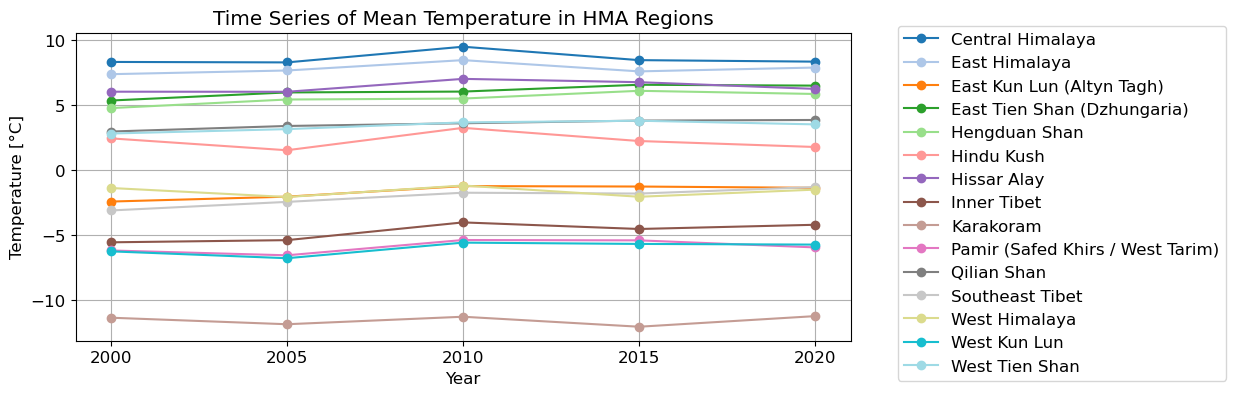

In [83]:
years = hma_t2m_mean_df['time'][hma_t2m_mean_df['Mean Temperature'].notna()]
# Plot mean temperature for each region
fig, ax = plt.subplots(figsize=(10, 4))
colors = cm.get_cmap('tab20', len(df_region_temps['Region'].unique()))  # Use a more colorful colormap

for i, (region, region_data) in enumerate(df_region_temps.groupby('Region')):
  ax.plot(region_data['Year'], region_data['Temperature'], marker='o', label=region, color=colors(i))

ax.set_title('Time Series of Mean Temperature in HMA Regions')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature [°C]')
ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
ax.grid(True)
ax.set_xticks(years);  # Set x-ticks to valid years only




### Precipitation
Research below revealed that the precipitation data of Era5 is larger than observation values.    
温婷婷,郭英香,董少睿, 东元祯,来晓玲.1979—2017年CRU、ERA5、CMFD格点降水 数据在青藏高原适用性评估.干旱区研究.


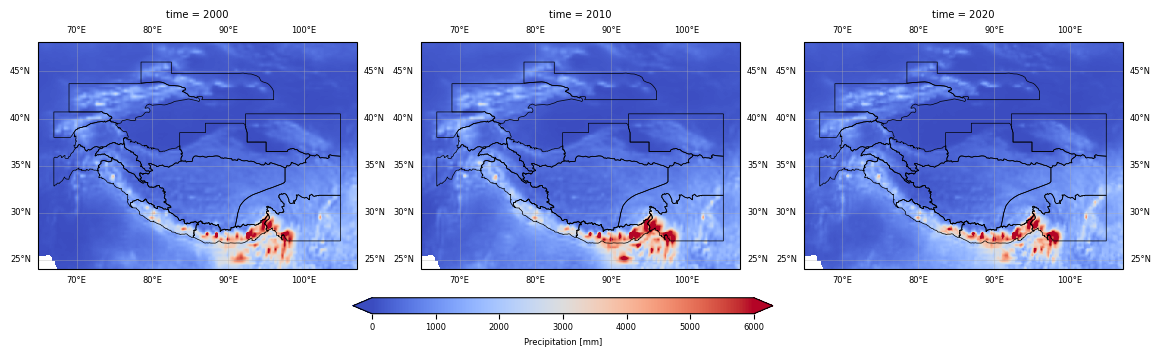

In [97]:
plt.rcParams.update({'font.size':6})
fig = plt.figure(figsize=(14,4))
### precipitation in 2000
ax = fig.add_subplot(1,3,1,projection=ccrs.PlateCarree())
# ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.tp.sel(time=2000).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False, vmin=0, vmax=6000)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
### precipitation in 2010
ax = fig.add_subplot(1,3,2,projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.tp.sel(time=2010).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False, vmin=0, vmax=6000)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
### precipitation in 2020
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.tp.sel(time=2020).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',  add_colorbar=False, vmin=0, vmax=6000)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.04])
fig.colorbar(ax.collections[0], cax=cbar_ax,  label='Precipitation [mm]', orientation='horizontal', extend='both', fraction=0.05, pad=0.05)


,time,Total Precipitation
0,2000,827.197837
1,2005,792.308174
2,2010,876.285511
3,2015,779.538652
4,2020,830.282301


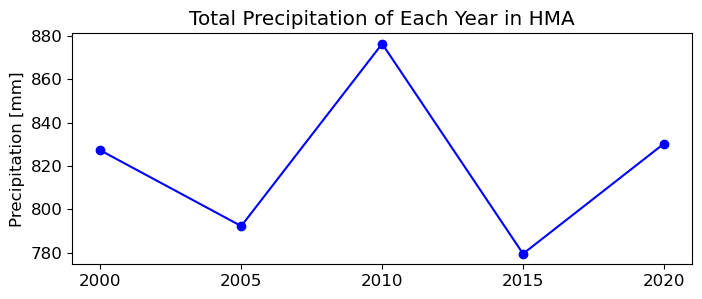

In [ ]:
hma_tp = dset_era5.tp.where(mask_da, drop=True)
hma_tp_mean = hma_tp.mean(dim=['latitude', 'longitude'])
plt.rcParams.update({'font.size': 12})  # Increase font size from 6 to 12
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title('Total Precipitation of Each Year in HMA')
ax.set_ylabel('Precipitation [mm]')
hma_tp_mean_df = hma_tp_mean.to_dataframe(name='Total Precipitation').reset_index()
ax.plot(hma_tp_mean_df['time'], hma_tp_mean_df['Total Precipitation'], marker='o', color='b')
years = hma_tp_mean_df['time']
ax.set_xticks(years)
hma_tp_mean_df


### Evaporation

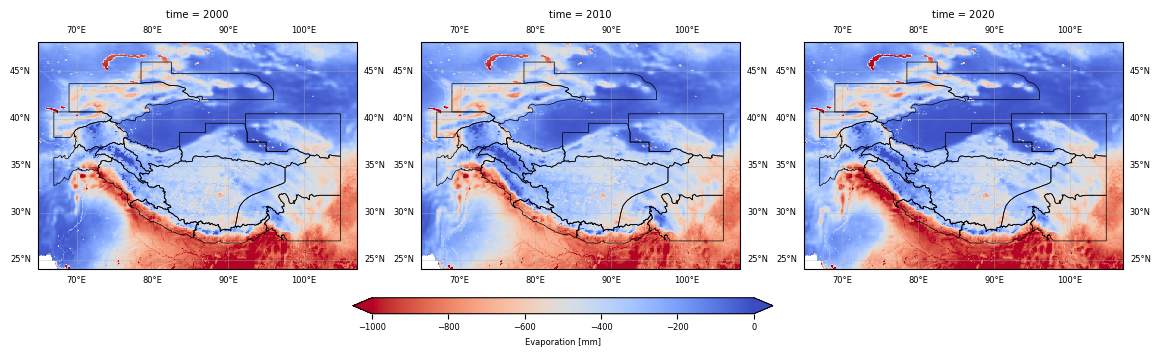

In [104]:
plt.rcParams.update({'font.size':6})
fig = plt.figure(figsize=(14,4))
### precipitation in 2000
ax = fig.add_subplot(1,3,1,projection=ccrs.PlateCarree())
# ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.te.sel(time=2000).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                 cmap=cm.coolwarm.reversed(), add_colorbar=False, vmin=-1000, vmax=0)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
### precipitation in 2010
ax = fig.add_subplot(1,3,2,projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.te.sel(time=2010).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                 cmap=cm.coolwarm.reversed(), add_colorbar=False, vmin=-1000, vmax=0)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
### precipitation in 2020
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
dset_era5.te.sel(time=2020).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                 cmap=cm.coolwarm.reversed(),  add_colorbar=False, vmin=-1000, vmax=0)
hma_gtng.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, zorder=3)
cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.04])
fig.colorbar(ax.collections[0], cax=cbar_ax,  label='Evaporation [mm]', orientation='horizontal', extend='both', fraction=0.05, pad=0.05)

